# Generative Adversarial Networks

Surgiu por meados de 2014 em um dos papers de Ian J. Goodfellow

### Import necessários

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
import matplotlib.animation as animation
from torchvision import datasets, transforms, utils

%matplotlib inline

In [2]:
batch_size = 128
learning_rate = 0.0002

in_gen = 100
out_gen = 784

in_dis = 784
out_dis = 1


### Carregando dataset

In [3]:
transform_data = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

dataset_mnist = datasets.MNIST('../data', train=True, download=True, transform=transform_data)

data_loader = torch.utils.data.DataLoader(dataset_mnist ,batch_size=batch_size, shuffle=True)

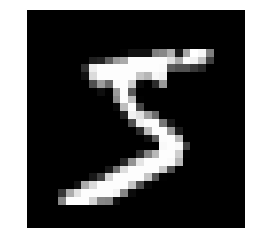

In [4]:
img = next(iter(data_loader.dataset))
plt.figure()
plt.imshow(img[0].view(28,28) , cmap='gray')
plt.axis('off')
plt.show()

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

## Generator 

Responsável por gerar uma imagem a partir de um vetor

<img src="https://cdn-images-1.medium.com/max/800/1*tNs5-ymkehhOmQ34qFPmGg.png" />
<small>Machine Learning is Fun<small>

In [6]:
class Gen(nn.Module):
    
    def __init__(self):
        super(Gen, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(1024, 784),
            nn.Tanh() 
        )
        
    def forward(self,x):
        return self.main(x)

In [7]:
net_g = Gen().to(device)

print(net_g)

Gen(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


## Discriminator

Responsável por distinguir entre uma figura falsa e uma verdadeira

<img src="https://cdn-images-1.medium.com/max/800/1*DzgbacOHVg7eA-NI3bqljg.png" />
<small>Source: Machine Learning is Fun</small>

In [8]:
class Dis(nn.Module):
    
    def __init__(self):
        super(Dis, self).__init__()
        
        self.main = nn.Sequential(

            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid() 
        )
        
    def forward(self,x):
        out = self.main(x)
        out = out.view(out.size(0), -1)
        return out
    
    

In [9]:
net_d = Dis().to(device)

print(net_d)

Dis(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout(p=0.3)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Dropout(p=0.3)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Dropout(p=0.3)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


### Treinando a Rede Neural GAN

<img src="https://cdn-images-1.medium.com/max/800/1*XO7aeFzFj1sxQsSq0y8J6Q.gif">
<smal>Source: <a href="https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f">GANs from Scratch 1: A deep introduction.</a></small>

In [11]:
def train_gen(net, dis_outputs, real_labels):

    g_loss = criterion(dis_outputs, real_labels)
    
    g_loss.backward()
    optimizer_g.step()
    
    return g_loss

In [38]:
def train_dis(net, images, real_labels, fake_images, fake_labels): 

    output_real = net(images)
    real_loss = criterion(output_real, real_labels)
    
    output_fake = net(fake_images)
    fake_loss = criterion(output_fake, fake_labels)
    
    total_loss = real_loss + fake_loss
    total_loss.backward()
    optimizer_d.step()
    
    return total_loss, real_loss, fake_loss

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
iters = 0

num_epochs = 100

fixed_noise = torch.randn(img[0].shape[0], in_gen, device=device)

criterion = nn.BCELoss()

optimizer_d = optim.Adam(net_d.parameters(), lr=learning_rate)
optimizer_g = optim.Adam(net_g.parameters(), lr=learning_rate)

print("Starting Training Loop...")
for epoch in range(num_epochs):

    for i, (images, _) in enumerate(data_loader):
        
        b_size = images.shape[0]
        images = images.view(b_size, 784)
        
        images = images.to(device)
        real_labels = torch.ones(b_size, device=device)
        
        noise = torch.randn(b_size, in_gen, device=device)
        fake_images = net_g(noise)
        fake_labels = torch.zeros(b_size, device=device)

        # Discriminator Train
        net_d.zero_grad()
        d_loss, real_score, fake_score = train_dis(net_d, images, real_labels, fake_images, fake_labels)         
       
        noise = torch.randn(b_size, in_gen, device=device)
        fake_images = net_g(noise)
        d_outputs = net_d(fake_images)
        
        # Generator Train
        net_g.zero_grad()
        g_loss = train_gen(net_g, d_outputs, real_labels)


        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100== 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    

    # Results of a batch
    print(f'[{epoch}/{num_epochs}] - D_loss: {d_loss:.4f}\tG_loss: {g_loss:.4f}')

Starting Training Loop...


/home/gabriel/.local/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/gabriel/.local/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[0/100] - D_loss: 2.2607	G_loss: 0.4105
[1/100] - D_loss: 1.7640	G_loss: 0.3417
[2/100] - D_loss: 0.8764	G_loss: 1.7099
[3/100] - D_loss: 0.3942	G_loss: 2.9754
[4/100] - D_loss: 0.8395	G_loss: 1.7176
[5/100] - D_loss: 0.3872	G_loss: 2.7240
[6/100] - D_loss: 0.8344	G_loss: 2.7982
[7/100] - D_loss: 0.6472	G_loss: 3.3952
[8/100] - D_loss: 0.7735	G_loss: 2.1998
[9/100] - D_loss: 0.4010	G_loss: 3.4302
[10/100] - D_loss: 0.5526	G_loss: 2.6693
[11/100] - D_loss: 0.6308	G_loss: 2.1473
[12/100] - D_loss: 0.6527	G_loss: 2.2902
[13/100] - D_loss: 0.5907	G_loss: 2.9722
[14/100] - D_loss: 0.8158	G_loss: 1.7602
[15/100] - D_loss: 0.9069	G_loss: 2.8851
[16/100] - D_loss: 0.6695	G_loss: 2.1653
[17/100] - D_loss: 0.7108	G_loss: 1.7918
[18/100] - D_loss: 0.6271	G_loss: 1.9683
[19/100] - D_loss: 0.7050	G_loss: 2.2229
[20/100] - D_loss: 0.8886	G_loss: 1.6904
[21/100] - D_loss: 0.6835	G_loss: 1.7243
[22/100] - D_loss: 0.7449	G_loss: 2.2213
[23/100] - D_loss: 0.9186	G_loss: 1.6688
[24/100] - D_loss: 0.8847	

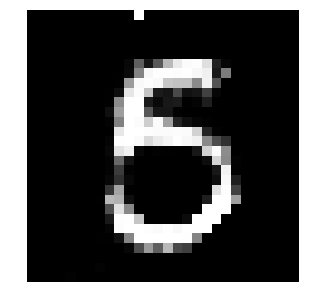

In [37]:
fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i[0].view(28,28),(0,1)), animated=True, cmap="gray")] for i in img_list[::34]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())